In [1]:
from models.water import EW
from models.landuse import BE2, GE3, SL1_BE3
from models.ALL import model_dictionnary

from graphmodels.graphmodel import GraphModel, merge_models

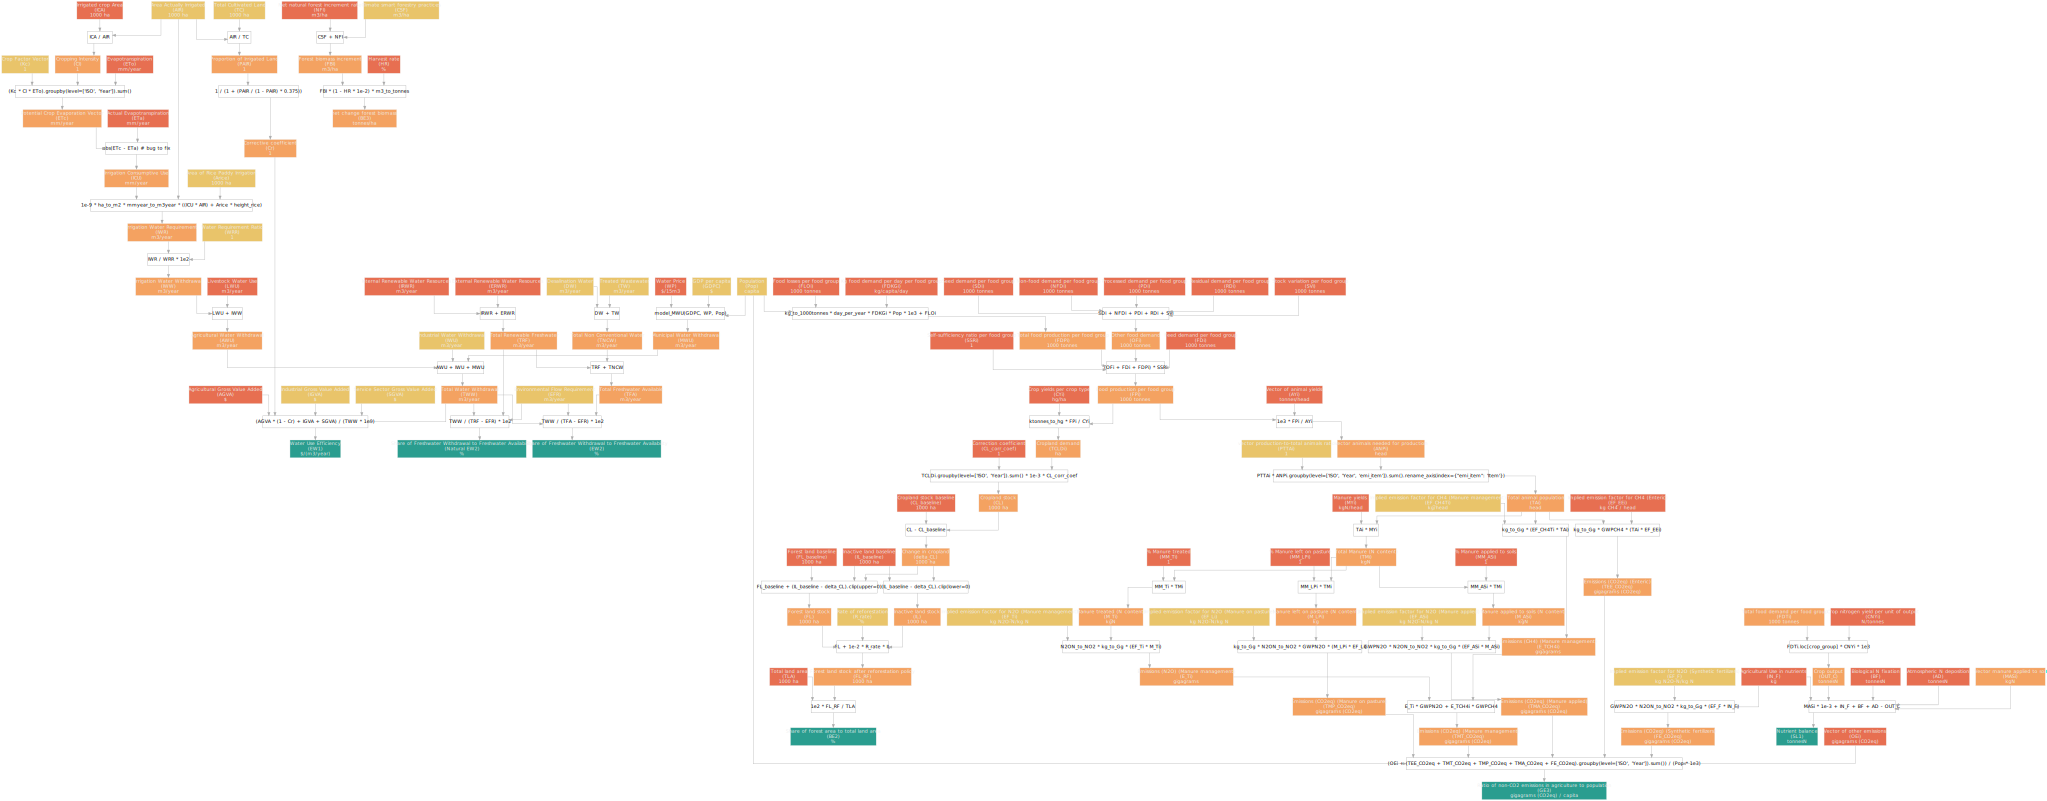

In [3]:
model_dictionnary['full_model'].draw()

In [11]:
import pandas as pd

def get_duplicated_nodes(list_of_graph_specs):
    id_type_df = get_id_type_df(list_of_graph_specs)
    return id_type_df.loc[id_type_df.id.duplicated()].id.tolist()


def get_id_type_df(list_of_graph_specs):
    id_type_df = [[(d, node['type']) for d, node in graph_spec.items()]
                  for graph_spec in list_of_graph_specs]
    id_type_df = pd.DataFrame(sum(id_type_df, []), columns=['id', 'type']).drop_duplicates()
    return id_type_df

def get_nodes_df(node_list):
    nodes_df = pd.DataFrame(node_list)
    assert nodes_df[['unit', 'name']].drop_duplicates().shape[0] == 1, f'{node_id} has different name or unit across specifications'
    return nodes_df

def get_node_from_list_of_specs(node_id, list_of_graph_specs):
    node_list = [nodes[node_id] for nodes in list_of_graph_specs if node_id in nodes.keys()]
    return node_list


def merge_nodes(node_list):
    nodes_to_merge = get_nodes_df(node_list)      

    if 'variable' in nodes_to_merge.type.unique():
        computation = nodes_to_merge.dropna(subset=['computation']).computation.unique()[0]
        unit = nodes_to_merge.unit.unique()[0]
        name = nodes_to_merge.name.unique()[0]
        return {'name': name, 'type': 'variable', 'unit': unit, 'computation': computation}
    elif set(['input', 'output']) <= set(nodes_to_merge.type.unique()):
        computation = nodes_to_merge.dropna(subset=['computation']).computation.unique()[0]
        unit = nodes_to_merge.unit.unique()[0]
        name = nodes_to_merge.name.unique()[0]
        return {'name': name, 'type': 'variable', 'unit': unit, 'computation': computation}

    else:
        
        return nodes_to_merge.drop_duplicates().to_dict(orient='records')[0]


def concatenate_graph_specs(list_of_graph_specs):
    '''Concatenate a list of graph specifications.

    - Duplicated nodes are removed.
    - Nodes that are inputs in some and outputs in other becomes variables.
    '''

    concatenated_specs = {}
    for graph_specs in list_of_graph_specs:
        concatenated_specs.update(graph_specs)


    duplicated_nodes = get_duplicated_nodes(list_of_graph_specs)

    merged_nodes = {}

    for node_id in duplicated_nodes:
        nodes_to_merge = get_node_from_list_of_specs(node_id, list_of_graph_specs)
        merged_node = merge_nodes(nodes_to_merge)
        merged_nodes[node_id] = merged_node
            
    concatenated_specs.update(merged_nodes)

    return concatenated_specs


def merge_models(model_list):
    concatenated_spec = concatenate_graph_specs([model.graph_specifications for model in model_list])
    merged_model = GraphModel(concatenated_spec)
    return merged_model

In [9]:
model_list = [EW, BE2, GE3, SL1_BE3]

graphmodel_list = []

for model in model_list:
    model_dict = model.model_dictionnary

    for name, gm in model_dict.items():
        graphmodel_list.append(gm)

full_model = merge_models(graphmodel_list)

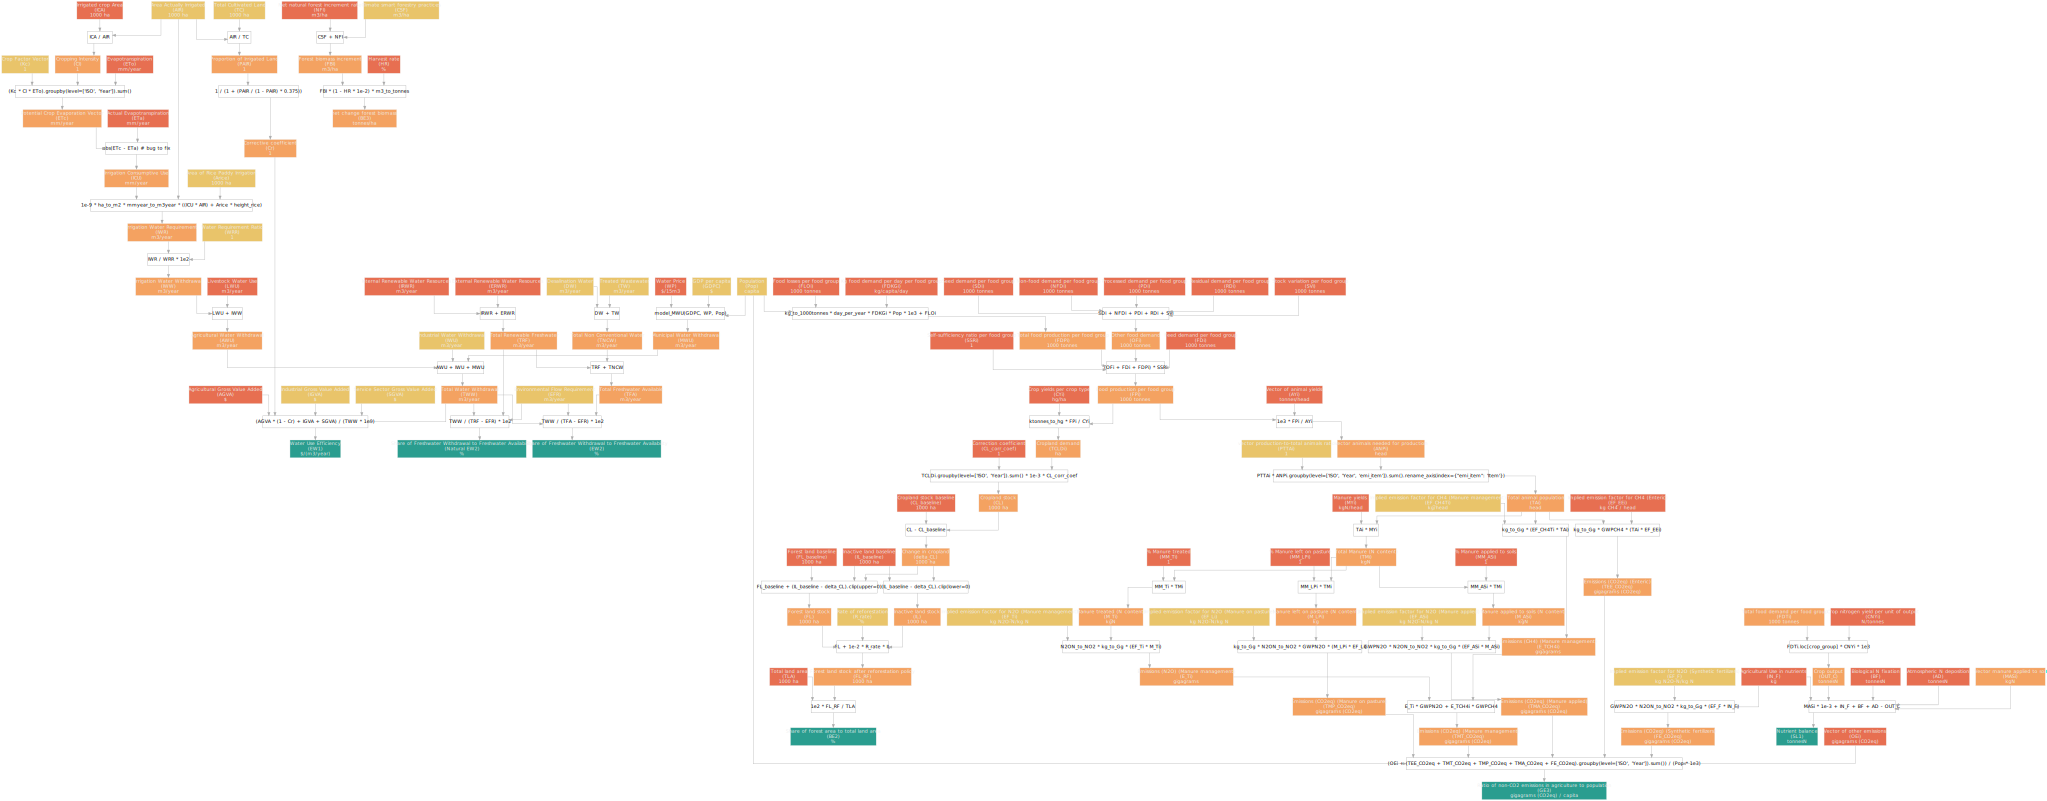

In [10]:
full_model.draw()